# An RNN model to generate sequences
RNN models can generate long sequences based on past data. This can be used to predict stock markets, temperatures, traffic or sales data based on past patterns. They can also be adapted to [generate text](https://docs.google.com/presentation/d/18MiZndRCOxB7g-TcCl2EZOElS5udVaCuxnGznLnmOlE/pub?slide=id.g139650d17f_0_1185). The quality of the prediction will depend on training data, network architecture, hyperparameters, the distance in time at which you are predicting and so on. But most importantly, it will depend on wether your training data contains examples of the behaviour patterns you are trying to predict.

<div class="alert alert-block alert-warning">
This is the solution file. The corresponding tutorial file is [01_RNN_generator_playground.ipynb](01_RNN_generator_playground.ipynb)
</div>

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import utils_prettystyle
import utils_batching
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.6.0


## Generate fake dataset

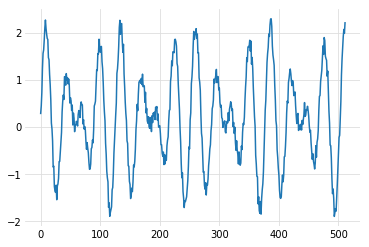

In [2]:
WAVEFORM_SELECT = 0 # select 0, 1 or 2

def create_time_series(datalen):
    # good waveforms
    frequencies = [(0.2, 0.15), (0.35, 0.3), (0.6, 0.55)]
    freq1, freq2 = frequencies[WAVEFORM_SELECT]
    noise = [np.random.random()*0.2 for i in range(datalen)]
    x1 = np.sin(np.arange(0,datalen) * freq1)  + noise
    x2 = np.sin(np.arange(0,datalen) * freq2)  + noise
    x = x1 + x2
    return x.astype(np.float32)

DATA_SEQ_LEN = 1024*128
data = create_time_series(DATA_SEQ_LEN)
plt.plot(data[:512])
plt.show()

## Hyperparameters

In [3]:
RNN_CELLSIZE = 64   # size of the RNN cells
NLAYERS = 2         # number of stacked RNN cells (needed for tensor shapes but code must be changed manually)
SEQLEN = 16         # unrolled sequence length
BATCHSIZE = 32      # mini-batch size
DROPOUT_PKEEP = 0.7 # probability of neurons not being dropped (should be between 0.5 and 1)

## Visualize training sequences
This is what the neural network will see during training.

Sample shape: (32, 16)
Label shape: (32, 16)
Excerpt from first batch:


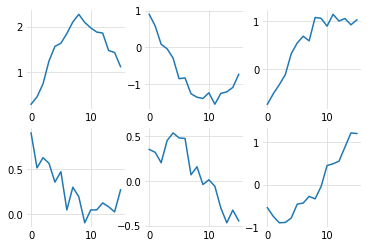

In [4]:
# The function dumb_minibatch_sequencer splits the data into batches of sequences sequentially.
for samples, labels, epoch in utils_batching.dumb_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=1):
    break
print("Sample shape: " + str(samples.shape))
print("Label shape: " + str(labels.shape))
print("Excerpt from first batch:")
subplot = 231
for i in range(6):
    plt.subplot(subplot)
    plt.plot(samples[i])
    subplot += 1
plt.show()

## The model definition
When executed, this function instantiates the Tensorflow graph for our model.
![deep RNN schematic](images/deep_rnn.png)

In [5]:
def model_rnn_fn(features, Hin, labels, dropout_pkeep):
    X = features
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
    
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(NLAYERS)]
    # dropout useful between cell layers only: no output dropout on last cell
    dcells = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob = dropout_pkeep) for cell in cells[:-1]]
    dcells.append(cells[-1])
    # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(dcells, state_is_tuple=False)
    # X[BATCHSIZE, SEQLEN, 1], Hin[BATCHSIZE, RNN_CELLSIZE*NLAYERS]
    # the sequence unrolling happens here
    Yn, H = tf.nn.dynamic_rnn(cell, X, initial_state=Hin)
    # Yn[BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    Yn = tf.reshape(Yn, [batchsize*seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1) # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1]) # Yr [BATCHSIZE, SEQLEN, 1]
    Yout = Yr[:,-1,:] # Last output Yout [BATCHSIZE, 1]
    
    loss = tf.losses.mean_squared_error(Yr, labels) # labels[BATCHSIZE, SEQLEN, 1]
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    
    return Yout, H, loss, train_op

## Instantiate the model

In [6]:
# placeholder for inputs
Hin = tf.placeholder(tf.float32, [None, RNN_CELLSIZE * NLAYERS])
samples = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
labels = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
dropout_pkeep = tf.placeholder(tf.float32)

# instantiate the model
Yout, H, loss, train_op = model_rnn_fn(samples, Hin, labels, dropout_pkeep)

## Inference
This is a generative model: run one trained RNN cell in a loop

In [7]:
def prediction_run(prime_data, run_length):
    H_ = np.zeros([1, RNN_CELLSIZE * NLAYERS]) # zero state initially
    Yout_ = np.zeros([1, 1])
    data_len = prime_data.shape[0]

    # prime the state from data
    if data_len > 0:
        Yin = np.array(prime_data)
        Yin = np.reshape(Yin, [1, data_len, 1]) # reshape as one sequence
        feed = {Hin: H_, samples: Yin, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
    
    # run prediction
    # To generate a sequence, run a trained cell in a loop passing as input and input state
    # respectively the output and output state from the previous iteration.
    results = []
    for i in range(run_length):
        Yout_ = np.reshape(Yout_, [1, 1, 1]) # batch of a single sequence of a single vector with one element
        feed = {Hin: H_, samples: Yout_, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
        results.append(Yout_[0,0])
        
    return np.array(results)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [8]:
# first input state
Hzero = np.zeros([BATCHSIZE, RNN_CELLSIZE * NLAYERS])
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run([init])

[None]

## The training loop
You can re-execute this cell to continue training

In [9]:
NB_EPOCHS = 10

H_ = Hzero
losses = []
indices = []
for i, (next_samples, next_labels, epoch) in enumerate(utils_batching.rnn_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=NB_EPOCHS)):
    next_samples = np.expand_dims(next_samples, axis=2) # model wants 3D inputs [BATCHSIZE, SEQLEN, 1] 
    next_labels = np.expand_dims(next_labels, axis=2)

    feed = {Hin: H_, samples: next_samples, labels: next_labels, dropout_pkeep: DROPOUT_PKEEP}
    Yout_, H_, loss_, _ = sess.run([Yout, H, loss, train_op], feed_dict=feed)
    # print progress
    if i%100 == 0:
        print("epoch " + str(epoch) + ", batch " + str(i) + ", loss=" + str(np.mean(loss_)))
    if i%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(i)

epoch 0, batch 0, loss=1.1734147
epoch 0, batch 100, loss=0.02817759
epoch 0, batch 200, loss=0.026739964
epoch 1, batch 300, loss=0.029787257
epoch 1, batch 400, loss=0.023831423
epoch 1, batch 500, loss=0.026745096
epoch 2, batch 600, loss=0.04187195
epoch 2, batch 700, loss=0.02271581
epoch 3, batch 800, loss=0.021025795
epoch 3, batch 900, loss=0.020637564
epoch 3, batch 1000, loss=0.020998888
epoch 4, batch 1100, loss=0.027018655
epoch 4, batch 1200, loss=0.018919144
epoch 5, batch 1300, loss=0.02155285
epoch 5, batch 1400, loss=0.020739008
epoch 5, batch 1500, loss=0.023802
epoch 6, batch 1600, loss=0.020533253
epoch 6, batch 1700, loss=0.019923083
epoch 7, batch 1800, loss=0.01712379
epoch 7, batch 1900, loss=0.01785953
epoch 7, batch 2000, loss=0.023273062
epoch 8, batch 2100, loss=0.01576007
epoch 8, batch 2200, loss=0.0149036385
epoch 9, batch 2300, loss=0.017866734
epoch 9, batch 2400, loss=0.01987784
epoch 9, batch 2500, loss=0.019393606


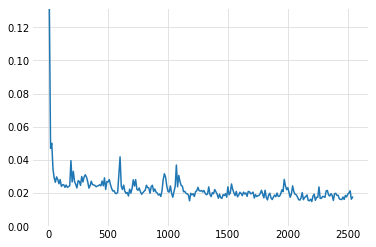

In [10]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value for scaling
plt.plot(indices, losses)
plt.show()

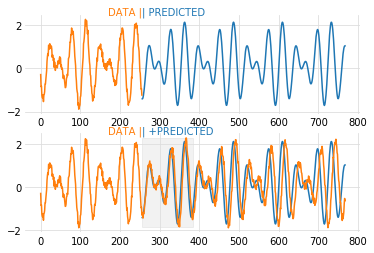

RMSE on 128 predictions (shaded area): 0.5073072414109203


In [11]:
PRIMELEN=256
RUNLEN=512
OFFSET=20

prime_data = data[OFFSET:OFFSET+PRIMELEN]

results = prediction_run(prime_data, RUNLEN)

disp_data = data[OFFSET:OFFSET+PRIMELEN+RUNLEN]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.subplot(211)
plt.text(PRIMELEN,2.5,"DATA |", color=colors[1], horizontalalignment="right")
plt.text(PRIMELEN,2.5,"| PREDICTED", color=colors[0], horizontalalignment="left")
displayresults = np.ma.array(np.concatenate((np.zeros([PRIMELEN]), results)))
displayresults = np.ma.masked_where(displayresults == 0, displayresults)
plt.plot(displayresults)
displaydata = np.ma.array(np.concatenate((prime_data, np.zeros([RUNLEN]))))
displaydata = np.ma.masked_where(displaydata == 0, displaydata)
plt.plot(displaydata)
plt.subplot(212)
plt.text(PRIMELEN,2.5,"DATA |", color=colors[1], horizontalalignment="right")
plt.text(PRIMELEN,2.5,"| +PREDICTED", color=colors[0], horizontalalignment="left")
plt.plot(displayresults)
plt.plot(disp_data)
RMSELEN=128
plt.axvspan(PRIMELEN, PRIMELEN+RMSELEN, color='grey', alpha=0.1, ymin=0.05, ymax=0.95)
plt.show()

rmse = math.sqrt(np.mean((data[OFFSET+PRIMELEN:OFFSET+PRIMELEN+RMSELEN] - results[:RMSELEN])**2))
print("RMSE on {} predictions (shaded area): {}".format(RMSELEN, rmse))

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.